In [1]:
import numpy as np
from hurst_fitting import *
from dukascopy_reader import Reader
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
plt.style.use('dark_background')

In [2]:
params = {
    'font.size': 14,
    'figure.figsize': (11,18),
    'axes.labelsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
}
plt.rcParams.update(params)

In [3]:
LAGS = 15
START_DATE = datetime(2019,7,29)
END_DATE = datetime(2019,8,9)

In [4]:
reader = Reader(fname='Bund.zip')

In [5]:
reader.load(START_DATE, END_DATE)
df = reader.df

In [6]:
df.head()

,Ask,AskVolume,Bid,BidVolume,Mid,Time
Time,,,,,,
2019-08-01 07:00:00.095,174.913,0.0150,174.882,0.0002,174.8975,2019-08-01 07:00:00.095
2019-08-01 07:00:00.146,174.923,0.0151,174.887,0.0002,174.9050,2019-08-01 07:00:00.146
2019-08-01 07:00:00.257,174.923,0.0151,174.883,0.0002,174.9030,2019-08-01 07:00:00.257
2019-08-01 07:00:00.360,174.933,0.0151,174.898,0.0002,174.9155,2019-08-01 07:00:00.360
2019-08-01 07:00:03.058,174.932,0.0151,174.898,0.0002,174.9150,2019-08-01 07:00:03.058


## Hurst index estimation at various sampling frequencies

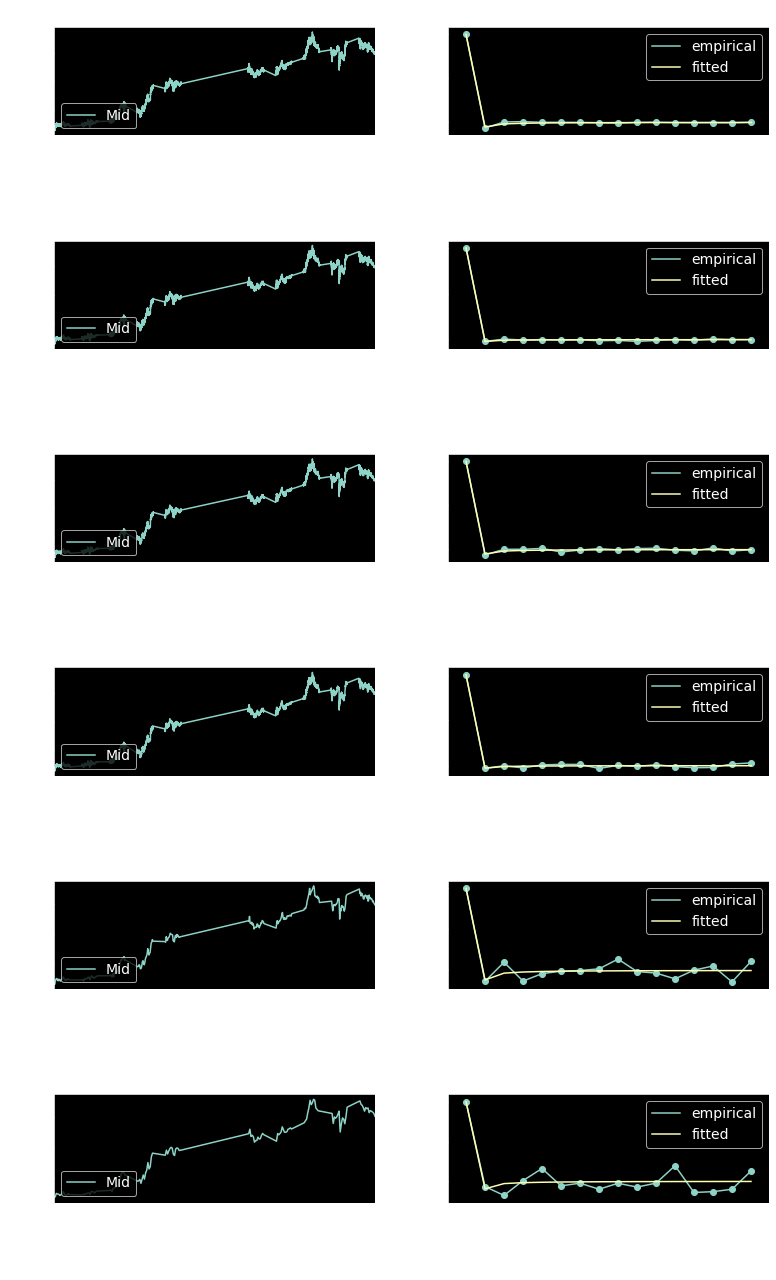

In [8]:
fig, axes = plt.subplots(nrows=6, ncols=2)

freqs = ['100ms', '1S', '30S', '1Min', '30Min', '1H']

fitter = Hurst_fitter(n_lags=LAGS)

for freq, ax_row in zip(freqs, axes):
    # dropna otherwise there will be gaps in the series because of non-market hours
    df_sampled = df['Mid'].resample(freq).first().dropna()
    
    ax = ax_row[0]
    df_sampled.plot(kind='line', ax=ax)
    ax.set_ylabel('price')
    ax.legend(loc='lower left')

    ax.set_title('{} sampling'.format(freq))

    fitter.df = df_sampled
    H_fit = fitter.fit()
    
    ax = ax_row[1]
    ys = acf(fitter.df_inc, nlags=LAGS)
    ys_fit = fitter.autocorr_frac_noise_range(H_fit)
    ax.plot(fitter.lag_range, ys, label='empirical')
    ax.scatter(fitter.lag_range, ys, marker='o')
    ax.plot(fitter.lag_range, ys_fit, label='fitted')
    
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(x)))
    ax.set_xlabel('H={:.2f} (fitted) '.format(H_fit))
    ax.set_ylabel('autocorrelogram')
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    ax.legend(loc='upper right')
    
plt.tight_layout()
plt.show()

## Conclusion
At high frequency, the price signal tends to mean-revert (negative autocorrelation of returns, fitted $H<0.5$).

This signal seems to remain mean-reverting at lower frequencies.